In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import cPickle
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV
from astropy.table import Table
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
#get data
train = Table().read('PhotoZFileA.vot' )
test = Table().read('PhotoZFileB.vot' )

In [3]:
def relativeAbsoluteError(model, features, spec_z):   
    error = np.median(abs((model.predict(features) - spec_z) / ( 1 + spec_z)))
    return error

In [34]:
def fit(M, T, ridge=False, lasso=False, standard=True, alpha=0.05):
   
    if standard:
        model = LinearRegression(fit_intercept=True)
    elif ridge:
        model = Ridge(alpha=alpha, fit_intercept=True, normalize=True)
    elif lasso:
        model = Lasso(alpha=alpha, fit_intercept=True, normalize=True)
    
    res = model.fit(M, T)
    predicted = res.predict(M)
    
    return model, res, predicted

# Feature selection

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


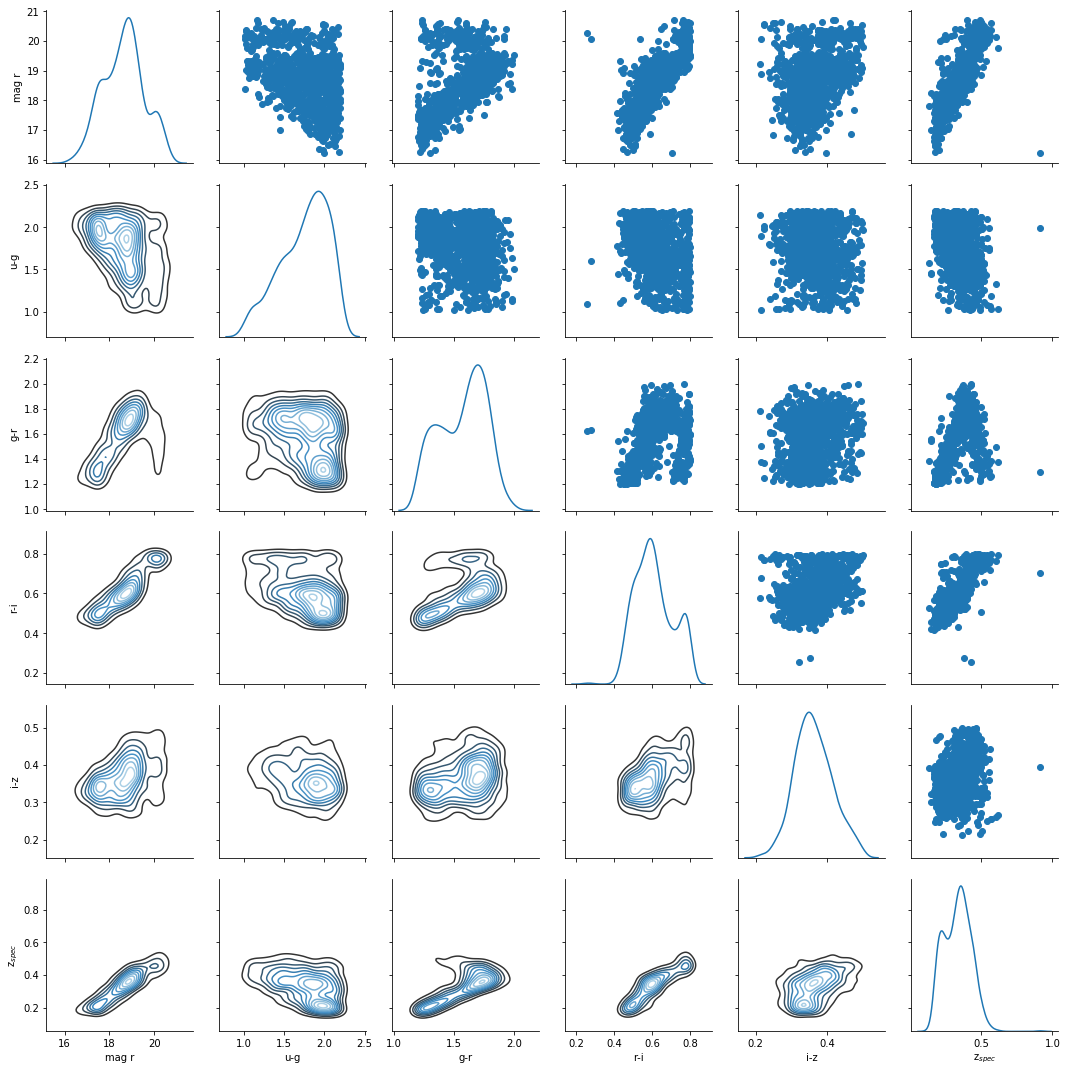

In [5]:
#visualisation of the dataset
X = np.vstack((train["mag_r"].data, train["u-g"].data, train["g-r"].data, train["r-i"].data, train["i-z"].data, train["z_spec"].data)).T

df = pd.DataFrame(X[0:1000, :], columns=['mag r', 'u-g', 'g-r', 'r-i', 'i-z', r'z$_{spec}$'])
g = sns.PairGrid(df, diag_sharey=False)

g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)
g.savefig('data.png')

In [6]:
scl = StandardScaler()

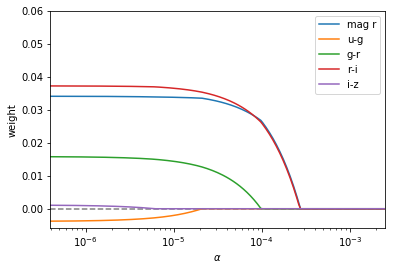

In [82]:
# Feature selection using Lasso
X = np.vstack((train["mag_r"].data, train["u-g"].data, train["g-r"].data, train["r-i"].data, train["i-z"].data, train["z_spec"].data)).T
n_features = 5
x = X[:,0:n_features]
y = X[:,n_features]

scl.fit(x)
scl.transform(x)
coef = []
alpha_range = np.logspace(-6.5,-2.6,200)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)

for alpha in alpha_range:
    model, res, predicted = fit(scl.transform(x), y, lasso = True, standard=False, alpha = alpha)
    coef.append(model.coef_)

plt.axhline(linestyle='--', color='k', alpha=0.5 )
plot = plt.semilogx(alpha_range,coef)
plt.legend(plot, ['mag r', 'u-g', 'g-r', 'r-i', 'i-z'])
plt.axis(ymax = 0.06, xmin = 10**-6.4, xmax = 10**-2.6)
plt.xlabel(r'$\alpha$')
plt.ylabel('weight')
plt.savefig('Lasso.png')

# Linear Regression

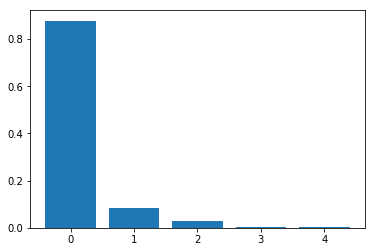

optimal alpha 0.174752840001
training error (ridge):  0.0148336537011
training error (only ridge on projected data):  0.0143329854648
training error (use rotated data to predict):  0.0135744629157
generalisation error:  0.0145505637348


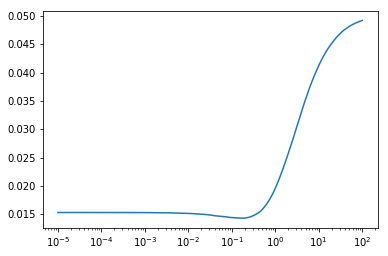

In [51]:
n = 5 #number of components
n_features = 5 # n predictors, 1 value
#X = np.vstack((train["mag_r"].data, train["g-r"].data, train["r-i"].data, train["z_spec"].data)).T
X = np.vstack((train["mag_r"].data, train["u-g"].data, train["g-r"].data, train["r-i"].data, train["i-z"].data, train["z_spec"].data)).T

x = X[:,0:n_features]
y = X[:,n_features]

pca = PCA(whiten=False, n_components=n)
pca.fit(X)

Xp = pca.inverse_transform(pca.transform(X))
xp = Xp[:,0:n_features]
yp = Xp[:,n_features]

plt.bar(np.arange(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.show()
#print pca.explained_variance_ratio_
#print pca.components_.T


error = []
alpha_range = np.logspace(-5,2,100)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)
for alpha in alpha_range:
    model, res, predicted = fit(xp, yp, ridge=True, standard=False, alpha = alpha)
    error.append(relativeAbsoluteError(model,x,y))
alpha_best = alpha_range[np.argmin(error)]

plt.semilogx(alpha_range, error)

#alpha_best = 0.0265108n60191
print "optimal alpha", alpha_best



#regular ridge regression
model, res, predicted = fit(x, y, ridge = True, standard = False, alpha = alpha_best)
print "training error (ridge): ", relativeAbsoluteError(model, x, y) 

#use ridge regression on data projected on eigenvectors
model, res, predicted = fit(xp, y, ridge = True, standard = False, alpha = alpha_best)
print "training error (only ridge on projected data): ", relativeAbsoluteError(model, x, y) 

#use projected input data by first predicting with ridge only
x_projected_ridge = pca.inverse_transform(pca.transform(np.vstack([x.T,predicted.T]).T))[:,0:n_features]
print "training error (use rotated data to predict): ", relativeAbsoluteError(model, x_projected_ridge, y) 


#generalisation with projection of input data
X_test = np.vstack((test["mag_r"].data, test["g-r"].data, test["r-i"].data, test["z_spec"].data)).T
X_test = np.vstack((test["mag_r"].data, test["u-g"].data, test["g-r"].data, test["r-i"].data, test["i-z"].data, test["z_spec"].data)).T

x_test = X_test[:,0:n_features]
y_test = X_test[:,n_features]
x_test_proj = pca.inverse_transform(pca.transform(np.vstack([x_test.T,model.predict(x_test)]).T))[:,0:n_features]
print "generalisation error: ", relativeAbsoluteError(model, x_test_proj,y_test) 


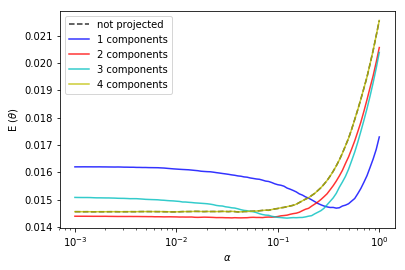

In [83]:
#only using the mag_r g-r and r-i data
X = np.vstack((train["mag_r"].data, train["g-r"].data, train["r-i"].data, train["z_spec"].data)).T
n_features = 3 # n predictors, 1 value

x = X[:,0:n_features]
y = X[:,n_features]

error_c = []
color = ['k','b','r','c','y']

for i in range(0,5):
    n = i #number of principle components
    if n != 0:
        pca = PCA(whiten=False, n_components=n)
        pca.fit(X)
        label = str(n) + " components"
        style = '-'
        Xp = pca.inverse_transform(pca.transform(X))
        xp = Xp[:,0:n_features]
        yp = Xp[:,n_features]
    else:
        label = "not projected"
        style = '--'
        xp = X[:,0:n_features]
        yp = X[:,n_features]
    scl.fit(xp)

    
    error = []
    alpha_range = np.logspace(-3,0,100)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)
    for alpha in alpha_range:
        model, res, predicted = fit(scl.transform(xp), yp, ridge=True, standard=False, alpha = alpha)
        error.append(relativeAbsoluteError(model,scl.transform(x),y))
    error_c.append(min(error))
    plt.semilogx(alpha_range, error, color = color[n], label = label, linestyle = style, alpha = 0.8  )


#plt.axhline(min(error_c), linestyle ='--', color = 'k', alpha = 0.5)
#plt.axis(xmin = 10**-2, xmax = 10**0, ymax = 0.017, ymin = 0.014)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'E ($\theta$)')
plt.legend(loc=2)
plt.savefig('PCA-components.png')

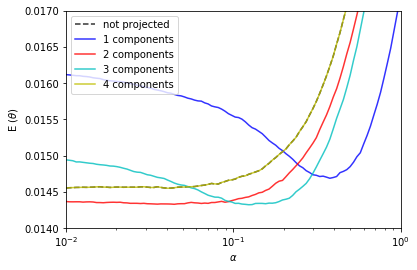

In [84]:
#only using the mag_r g-r and r-i data
X = np.vstack((train["mag_r"].data, train["g-r"].data, train["r-i"].data, train["z_spec"].data)).T
n_features = 3 # n predictors, 1 value

x = X[:,0:n_features]
y = X[:,n_features]

error_c = []
color = ['k','b','r','c','y']

for i in range(0,5):
    n = i #number of principle components
    if n != 0:
        pca = PCA(whiten=False, n_components=n)
        pca.fit(X)
        label = str(n) + " components"
        style = '-'
        Xp = pca.inverse_transform(pca.transform(X))
        xp = Xp[:,0:n_features]
        yp = Xp[:,n_features]
    else:
        label = "not projected"
        style = '--'
        xp = X[:,0:n_features]
        yp = X[:,n_features]

    scl.fit(xp)
    
    error = []
    alpha_range = np.logspace(-2,0,100)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)
    for alpha in alpha_range:
        model, res, predicted = fit(scl.transform(xp), yp, ridge=True, standard=False, alpha = alpha)
        error.append(relativeAbsoluteError(model,scl.transform(x),y))
    error_c.append(min(error))
    plt.semilogx(alpha_range, error, color = color[n], label = label, linestyle = style, alpha = 0.8 )


#plt.axhline(min(error_c), linestyle ='--', color = 'k', alpha = 0.5)
plt.axis(xmin = 10**-2, xmax = 10**0, ymax = 0.017, ymin = 0.014)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'E ($\theta$)')
plt.legend(loc=2)
plt.savefig('PCA-components-zoom.png')

In [85]:
#only using the mag_r g-r and r-i data

n = 3#number of components
n_features = 3 # n predictors, 1 value
X = np.vstack((train["mag_r"].data, train["g-r"].data, train["r-i"].data, train["z_spec"].data)).T
#X = np.vstack((train["mag_r"].data, train["u-g"].data, train["g-r"].data, train["r-i"].data, train["i-z"].data, train["z_spec"].data)).T

x = X[:,0:n_features]
y = X[:,n_features]

pca = PCA(whiten=False, n_components=n)
pca.fit(X)

Xp = pca.inverse_transform(pca.transform(X))
xp = Xp[:,0:n_features]
yp = Xp[:,n_features]

error = []
alpha_range = np.logspace(-5,2,100)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)
for alpha in alpha_range:
    model, res, predicted = fit(xp, yp, ridge=True, standard=False, alpha = alpha)
    error.append(relativeAbsoluteError(model,x,y))
alpha_best = alpha_range[np.argmin(error)]

#plt.semilogx(alpha_range, error)

#alpha_best = 0.0265108n60191
print "optimal alpha", alpha_best

X_test = np.vstack((test["mag_r"].data, test["g-r"].data, test["r-i"].data, test["z_spec"].data)).T
x_test = X_test[:,0:n_features]
y_test = X_test[:,n_features]

#regular ridge regression
model, res, predicted = fit((x), y, ridge = True, standard = False, alpha = alpha_best)
print "training error (ridge): ", relativeAbsoluteError(model, (x), y) 
print "genealisation error (ridge): ", relativeAbsoluteError(model, (x_test) ,y_test) 
coef = model.coef_
print "f = {0} * mag_r + {1} * (g-r) + {2} * (r-i) + {3}".format(coef[0],coef[1],coef[2],model.intercept_)

#use ridge regression on data projected on eigenvectors
model, res, predicted = fit((xp), y, ridge = True, standard = False, alpha = alpha_best)
print "training error (only ridge on projected data): ", relativeAbsoluteError(model, (x), y) 
print "generlaisation error (without projection): ", relativeAbsoluteError(model, (x_test) ,y_test) 

coef = model.coef_
print "f = {0} * mag_r + {1} * (g-r) + {2} * (r-i) + {3}".format(coef[0],coef[1],coef[2],model.intercept_)


#use projected input data by first predicting with ridge only
x_projected_ridge = pca.inverse_transform(pca.transform(np.vstack([x.T,predicted.T]).T))[:,0:n_features]
print "training error (use rotated data to predict): ", relativeAbsoluteError(model, (x_projected_ridge), y) 

#generalisation with projection of input data
x_test_proj = pca.inverse_transform(pca.transform(np.vstack([x_test.T,model.predict(x_test)]).T))[:,0:n_features]
print "generalisation error: ", relativeAbsoluteError(model, x_test_proj,y_test) 

optimal alpha 0.126185688307
training error (ridge):  0.0147439193686
genealisation error (ridge):  0.0148766493833
f = 0.0387967970179 * mag_r + 0.0878827313975 * (g-r) + 0.388503843928 * (r-i) + -0.769575824039
training error (only ridge on projected data):  0.0143181755592
generlaisation error (without projection):  0.0144617893178
f = 0.0268429033983 * mag_r + 0.0787892853016 * (g-r) + 0.561991676182 * (r-i) + -0.637365999782
training error (use rotated data to predict):  0.0133571980702
generalisation error:  0.0144430952081


#  Non Linear Regression

In [15]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
import time

In [100]:
n_features = 3 #5 # n predictors, 1 value
X = np.vstack((train["mag_r"].data, train["g-r"].data, train["r-i"].data, train["z_spec"].data)).T

x = X[:,0:n_features]
y = X[:,n_features]

In [79]:


kf = KFold(n_splits=10, shuffle=False) 
errorNN = []
alpha_range_NN = np.logspace(-10,1,100)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)
for alpha in alpha_range_NN:
    nn = MLPRegressor(activation='relu', solver='adam', alpha=alpha, hidden_layer_sizes=(3,), random_state = 3141)
    aerror = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        lgm_est = nn.fit(X_train, Y_train).predict(X_test)
        aerror.append( np.median(abs(lgm_est-Y_test)/(Y_test+1)))
    errorNN.append(np.mean(aerror))

print "lowest training error: ", min(errorNN)
print "best alpha", alpha_range_NN[np.argmin(errorNN)]


lowest training error:  0.0142475970368
best alpha 1e-05


In [96]:
alpha_best = alpha_range_NN[np.argmin(errorNN)]
nn = MLPRegressor(activation='relu', solver='adam', alpha=alpha_best, hidden_layer_sizes=(3,), random_state = 3141)

X_test = np.vstack((test["mag_r"].data, test["g-r"].data, test["r-i"].data, test["z_spec"].data)).T
x_test = X_test[:,0:n_features]
y_test = X_test[:,n_features]


lgm_est = nn.fit(x,y).predict(x)
print "training error: ", np.median(abs(lgm_est-y)/(y+1))

lgm_est = nn.fit(x,y).predict(x_test)
print "generalisation error: ", np.median(abs(lgm_est-y_test)/(y_test+1))


training error:  0.014215591515
generalisation error:  0.0143852777074


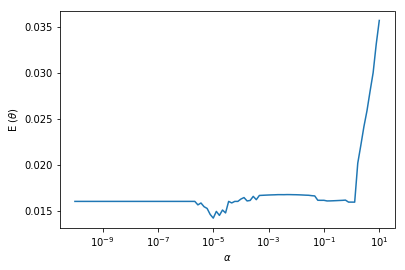

In [81]:
plt.semilogx(alpha_range_NN, errorNN)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'E ($\theta$)')
plt.savefig('alpha_NN.png')

In [74]:
#with standardising
kf = KFold(n_splits=10, shuffle=False) 
errorNN2 = []
scl.fit(x)
x = scl.transform(x)
alpha_range_NN = np.logspace(-10,1,100)#np.arange(0.0265108n60191-0.01,0.0265108n60191+0.01,0.001)
for alpha in alpha_range_NN:
    nn = MLPRegressor(activation='relu', solver='adam', alpha=alpha, hidden_layer_sizes=(3,), random_state = 3141)
    aerror = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        lgm_est = nn.fit(X_train, Y_train).predict(X_test)
        aerror.append( np.median(abs(lgm_est-Y_test)/(Y_test+1)))
    errorNN2.append(np.mean(aerror))

print "lowest training error: ", min(errorNN2)
print "best alpha", alpha_range_NN[np.argmin(errorNN2)]

lowest training error:  0.0145503487981
best alpha 0.464158883361


training error:  0.0145455920954
generalisation error:  0.0147342140901


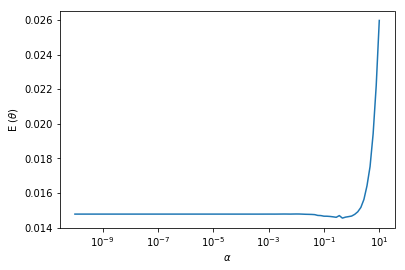

In [76]:
#with standardasing
alpha_best = alpha_range_NN[np.argmin(errorNN2)]
nn = MLPRegressor(activation='relu', solver='adam', alpha=alpha_best, hidden_layer_sizes=(3,), random_state = 3141)

X_test = np.vstack((test["mag_r"].data, test["g-r"].data, test["r-i"].data, test["z_spec"].data)).T
x_test = X_test[:,0:n_features]
y_test = X_test[:,n_features]


lgm_est = nn.fit(x,y).predict(x)
print "training error: ", np.median(abs(lgm_est-y)/(y+1))

lgm_est = nn.fit(x,y).predict(scl.transform(x_test))
print "generalisation error: ", np.median(abs(lgm_est-y_test)/(y_test+1))
plt.semilogx(alpha_range_NN, errorNN)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'E ($\theta$)')
plt.savefig('alpha_NN2.png')